<a href="https://colab.research.google.com/github/kunalpagarey/PyTocrh_Tutorial/blob/master/PyTorch_Style_Transfer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import torch
import torch.optim as opt
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [0]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

vgg = vgg.to(device)
# vgg

In [0]:
def load_image(img_path, max_size=600, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))
                                    ])
    image = in_transform(image).unsqueeze(0)
    return image


In [0]:
content = load_image('City.jpg').to(device)
style = load_image('fire.jpg', shape=content.shape[-2:]).to(device)

In [0]:
def convert_image(img):
    img = img.cpu().clone().detach().numpy()
    img = img.squeeze()
    img = img.transpose(1, 2, 0)
    img = img*np.array((0.5, 0.5, 0.5))+np.array((0.5, 0.5, 0.5))
    img = img.clip(0, 1)
    return img

(-0.5, 899.5, 599.5, -0.5)

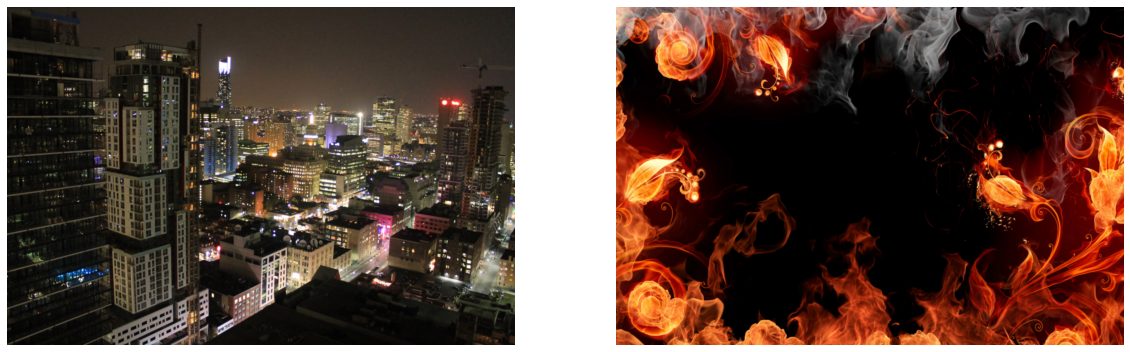

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_image(content))
ax1.axis('off')
ax2.imshow(convert_image(style))
ax2.axis('off')

In [0]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',    #For content features.
        '28': 'conv5_1'
        }

    features = {}

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    
    return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(img):
    _, d, h, w = img.size()
    img = img.view(d, h*w)
    gram = torch.mm(img, img.t())
    return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_alpha = 1
style_beta = 1e3

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
optimizer = opt.Adam([target], lr=0.003)
steps = 3000
show_every = 300
height, width, channels = convert_image(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_image = steps/300
count = 0

Iteration: 300, Total Loss = 1387.083251953125


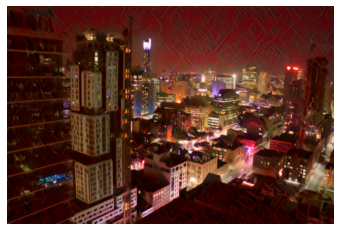

Iteration: 600, Total Loss = 675.5286254882812


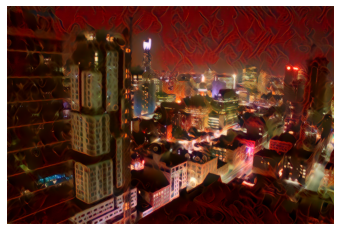

Iteration: 900, Total Loss = 456.9607238769531


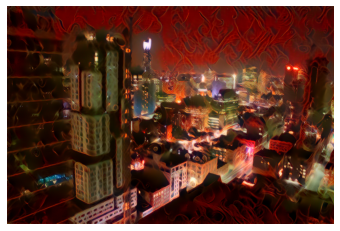

Iteration: 1200, Total Loss = 326.8721618652344


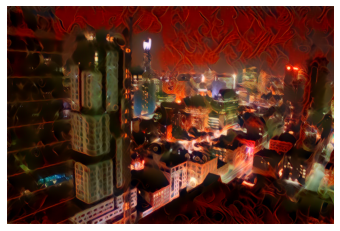

Iteration: 1500, Total Loss = 238.17987060546875


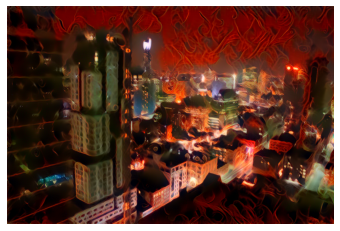

Iteration: 1800, Total Loss = 174.91082763671875


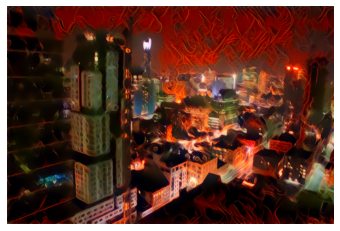

Iteration: 2100, Total Loss = 130.35430908203125


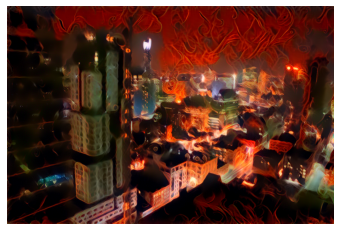

Iteration: 2400, Total Loss = 99.87745666503906


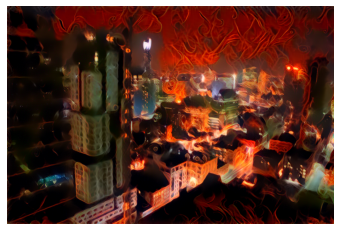

Iteration: 2700, Total Loss = 79.06332397460938


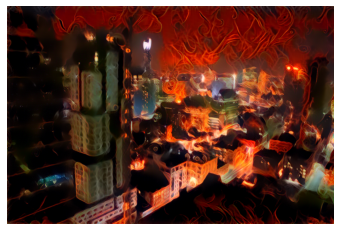

Iteration: 3000, Total Loss = 64.6838150024414


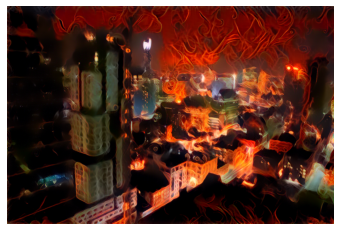

In [14]:
# Training
for s in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        style_layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += style_layer_loss/(d*h*w)
    
    total_loss = content_loss * content_alpha + style_loss * style_beta

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if s % show_every == 0:
        print("Iteration: {}, Total Loss = {}".format(s, total_loss))
        plt.imshow(convert_image(target))
        plt.axis('off')
        plt.show()
    
    if s % capture_image == 0:
        image_array[count] = convert_image(target)
        count += 1


(-0.5, 899.5, 599.5, -0.5)

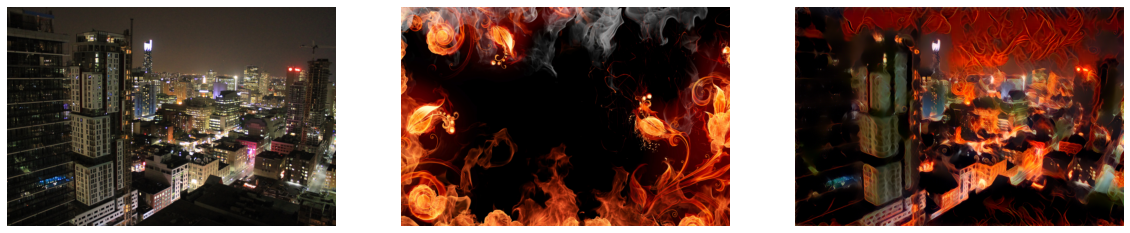

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(convert_image(content))
ax[0].axis('off')
ax[1].imshow(convert_image(style))
ax[1].axis('off')
ax[2].imshow(convert_image(target))
ax[2].axis('off')

In [0]:
import cv2

frame_height, frame_width, _ = convert_image(target).shape

video = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30,
                        (frame_width, frame_height))

for i in range(300):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    video.write(img)

video.release()